In [1]:
!rm -rf /kaggle/working/*

!pip install split-folders
!pip install tf_keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

from typing import List

tf.config.list_physical_devices('GPU')

2024-06-10 09:35:25.671925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 09:35:25.672029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 09:35:25.793800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import splitfolders
import shutil

In [4]:
def recursive_rmdir(folder):
    for item in os.listdir(folder):
        item_path = os.path.join(folder, item)
        
        if os.path.isdir(item_path):
            recursive_rmdir(item_path)
            os.rmdir(item_path)
        else:
            os.remove(item_path)
            

def organize_dataset(source_folder, destination_folder):    
    if os.path.exists(destination_folder):
        recursive_rmdir(destination_folder)
    
    # Discover all classes
    classes = set()
    for subfolder in os.listdir(source_folder):
        current_folder = os.path.join(source_folder, subfolder)
        discovered_classes = os.listdir(current_folder)
        classes = classes.union(discovered_classes)
    classes = list(classes)
    classes.sort()

    # Create a folder for each class
    if not os.path.exists(destination_folder):
        os.mkdir(destination_folder)
    
    for _class in classes:
        class_directory = os.path.join(destination_folder, _class)
        os.mkdir(class_directory)
    
    for subfolder in os.listdir(source_folder):
        current_path = os.path.join(source_folder, subfolder)
        for class_folder in os.listdir(current_path):
            current_path = os.path.join(source_folder, subfolder, class_folder)
            for file in os.listdir(current_path):
                
                file_source_path = os.path.join(
                    source_folder,
                    subfolder,
                    class_folder,
                    file
                )
                
                file_destination_path = os.path.join(
                    destination_folder,
                    class_folder,
                    file
                )
                
                shutil.copy2(
                    file_source_path,
                    file_destination_path,
                )

    return classes

In [5]:
def train_test_validation_split(
    source: str,
    destination: str,
    seed: int | None = None
):
    if seed is None:
        seed = np.random.randint(999999)
    print(f"Dataset's split seed is {seed}")

    if not os.path.isdir(destination):
        splitfolders.ratio(source, output=destination,
            seed=seed, ratio=(.6, .2, .2), move=False)

In [6]:
def get_true_and_predicted_labels(model, dataset):
    y_true = []
    y_pred = []
    
    for X_batch, y_batch in dataset:
        y_batch_pred = np.argmax(model.predict(X_batch, verbose=0), axis=1)
        
        y_true.append(y_batch)
        y_pred.append(y_batch_pred)
    
    y_true = [y_batch.numpy() for y_batch in y_true]
    
    return np.concatenate(y_true), np.concatenate(y_pred)

In [7]:
classes = organize_dataset(
    os.path.join("/", "kaggle", "input", "chest-xray-pneumoniacovid19tuberculosis"),
    os.path.join("/", "kaggle", "working", "temp"),
)
train_test_validation_split(
    os.path.join("/", "kaggle", "working", "temp"),
    os.path.join("/", "kaggle", "working", "dataset"),
    seed=0
)

print("Found classes:", classes)

Dataset's split seed is 0


Copying files: 7132 files [00:02, 2825.20 files/s]

Found classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [8]:
print("\n[ TRAIN DATASET ]")
train_dataset = keras.utils.image_dataset_from_directory(
    os.path.join("/", "kaggle", "working", "dataset", "train"),
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    interpolation='bilinear',
)

print("\n[ VALIDATION DATASET ]")
validation_dataset = keras.utils.image_dataset_from_directory(
    os.path.join("/", "kaggle", "working", "dataset", "val"),
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    interpolation='bilinear',
)

print("\n[ TEST DATASET ]")
test_dataset = keras.utils.image_dataset_from_directory(
    os.path.join("/", "kaggle", "working", "dataset", "test"),
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    interpolation='bilinear',
)


[ TRAIN DATASET ]
Found 4277 files belonging to 4 classes.

[ VALIDATION DATASET ]
Found 1425 files belonging to 4 classes.

[ TEST DATASET ]
Found 1430 files belonging to 4 classes.


In [9]:
# Model creation
vgg_16 = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="max",
)
vgg_16.trainable = False

model = keras.Sequential([
    keras.layers.Rescaling(1./255),
    vgg_16,
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dense(4, activation="softmax"),
], name="model")

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(name="loss"),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, name="optimizer"),
    metrics=["accuracy"],
)
model.build((None, 224, 224, 3))
model.summary()

model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=9999,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            model.name + '.keras',
            monitor='val_accuracy',
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            save_freq="epoch",
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=20,
            verbose=1,
            mode='auto',
        ),
    ],
)

# Fine tuning
vgg_16.trainable = True

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(name="loss"),
    optimizer=keras.optimizers.Adam(learning_rate=0.000001, name="optimizer"),
    metrics=["accuracy"],
)

model.summary()

model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=9999,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            model.name + '.keras',
            monitor='val_accuracy',
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            save_freq="epoch",
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=50,
            verbose=1,
            mode='auto',
        ),
    ],
)

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 4)                 16388     
                                                              

I0000 00:00:1718012217.576216      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/134 [==============================] - ETA: 0s - loss: 0.7813 - accuracy: 0.8433
Epoch 1: val_accuracy improved from -inf to 0.92351, saving model to model.keras
134/134 [==============================] - 40s 238ms/step - loss: 0.7813 - accuracy: 0.8433 - val_loss: 214.4757 - val_accuracy: 0.9235
Epoch 2/9999
134/134 [==============================] - ETA: 0s - loss: 10.7721 - accuracy: 0.9245
Epoch 2: val_accuracy improved from 0.92351 to 0.93263, saving model to model.keras
134/134 [==============================] - 27s 195ms/step - loss: 10.7721 - accuracy: 0.9245 - val_loss: 226.8999 - val_accuracy: 0.9326
Epoch 3/9999
134/134 [==============================] - ETA: 0s - loss: 0.8799 - accuracy: 0.9287
Epoch 3: val_accuracy did not improve from 0.93263
134/134 [==============================] - 26s 184ms/step - loss: 0.8799 - accuracy: 0.9287 - val_loss: 351.0543 - val_accuracy: 0.9249
Epoch 4/9999
134/134 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.

               precision    recall  f1-score   support

      COVID19       0.96      0.92      0.94       116
       NORMAL       0.94      0.93      0.94       318
    PNEUMONIA       0.97      0.98      0.97       856
TURBERCULOSIS       0.98      0.96      0.97       140

     accuracy                           0.96      1430
    macro avg       0.96      0.95      0.95      1430
 weighted avg       0.96      0.96      0.96      1430



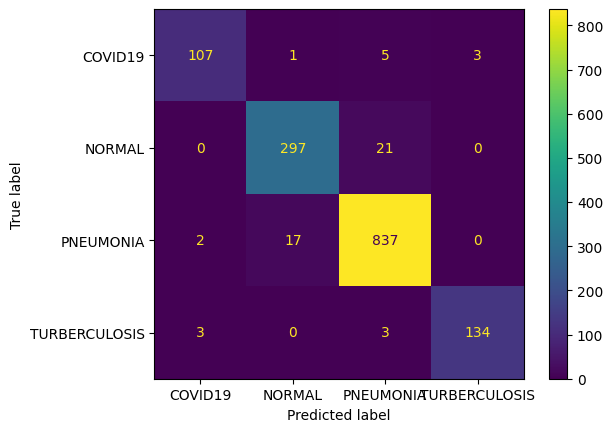

In [10]:
best_model = keras.saving.load_model("model.keras")
y_true, y_pred = get_true_and_predicted_labels(best_model, test_dataset)

model_accuracy = accuracy_score(y_true, y_pred)

# Saving confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=classes
)
plt.savefig("confusion_matrix.png")

print(classification_report(y_true, y_pred, target_names=classes))
with open("classification_report.txt", "w") as file:
    file.write(classification_report(y_true, y_pred, target_names=classes))

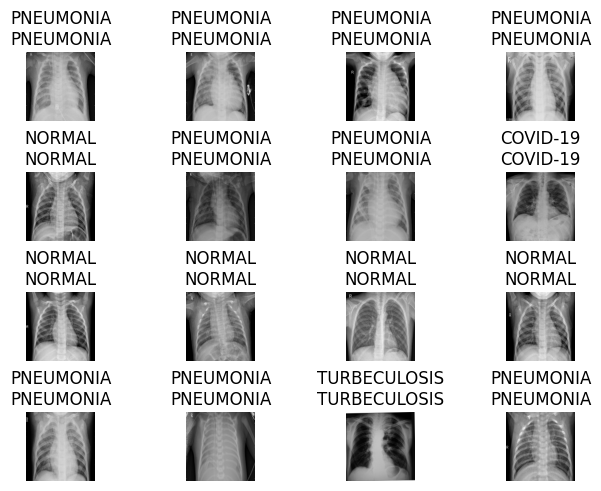

In [11]:
classes = ["COVID-19", "NORMAL", "PNEUMONIA", "TURBECULOSIS"]

rows, columns = 4, 4

for images, labels in test_dataset.take(1):
    plt.subplots(rows, columns, layout="constrained")
    i = 1
    
    predictions = np.argmax(best_model.predict(images, verbose=0), axis=1)
    
    for image, label_true, label_pred in zip(
        images.numpy()[:rows*columns],
        labels.numpy()[:rows*columns],
        predictions[:rows*columns]
    ):
        plt.subplot(rows, columns, i)
        plt.imshow(image.astype("uint8"))
        plt.title(f"{classes[label_true]}\n{classes[label_pred]}")
        plt.axis("off")
        i += 1